In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from sklearn.metrics.pairwise import haversine_distances
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
import fiona

all_uni_locations Sourced: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::colleges-and-universities/about

In [2]:
all_uni_locations= pd.read_csv('../data/Colleges_and_Universities.csv')
all_uni_locations

X             Y  OBJECTID  IPEDSID  \
0    -8.209134e+06  4.953591e+06         1   190752   
1    -8.267688e+06  4.940383e+06         2   481429   
2    -7.353945e+06  2.082890e+06         3   241739   
3    -1.006191e+07  4.664997e+06         4   455071   
4    -8.797220e+06  4.290711e+06         5   455141   
...            ...           ...       ...      ...   
6554 -9.317151e+06  5.308190e+06      6555   494889   
6555 -1.082780e+07  4.536689e+06      6556   494898   
6556 -8.145887e+06  4.983035e+06      6557   494904   
6557 -1.304572e+07  3.865065e+06      6558   494913   
6558 -1.270918e+07  5.819852e+06      6559   494922   

                                                   NAME  \
0     YESHIVA OF FAR ROCKAWAY DERECH AYSON RABBINICA...   
1                          UNIVERSAL TRAINING INSTITUTE   
2                UNIVERSIDAD ANA G. MENDEZ-CUPEY CAMPUS   
3                                   HEALING ARTS CENTER   
4                           AVEDA INSTITUTE-CHAPEL HILL   
...                                                 ...   
6554                              BAKER COLLEGE - FLINT   
6555         WELLSPRING SCHOOL OF ALLIED HEALTH-WICHITA   
6556                            ACCESS CAREERS-ISLANDIA   
6557          FRANCISCAN SCHOOL OF THEOLOGY - SAN DIEGO   
6558  UNIVERSITY OF MONTANA (THE) - BITTERROOT COLLE...   

                               ADDRESS          CITY STATE    ZIP  \
0                    802 HICKSVILLE RD  FAR ROCKAWAY    NY  11691   
1                 174 JEFFERSON STREET   PERTH AMBOY    NJ   8861   
2              1399 AVE. ANA G. MENDEZ      SAN JUAN    PR    926   
3     10073 MANCHESTER ROAD, SUITE 100     ST. LOUIS    MO  63122   
4      201 S. ESTES DRIVE, SPACE 200 B   CHAPEL HILL    NC  27514   
...                                ...           ...   ...    ...   
6554            1050 WEST BRISTOL ROAD         FLINT    MI  48507   
6555    650 N CARRIAGE PARKWAY, STE 55       WICHITA    KS  67208   
6556   1930 VETERANS HIGHWAY, SUITE 10      ISLANDIA    NY  11749   
6557                  5998 ALCALA PARK     SAN DIEGO    CA  92110   
6558              103 SOUTH 9TH STREET      HAMILTON    MT  59840   

               ZIP4  ...          ALIAS  SIZE_SET INST_SIZE  PT_ENROLL  \
0              5219  ...  NOT AVAILABLE        24         1       -999   
1              4106  ...  NOT AVAILABLE        -2         1       -999   
2              2602  ...     UAGM CUPEY        18         3       2780   
3     NOT AVAILABLE  ...  NOT AVAILABLE        -2         1        131   
4              7001  ...  NOT AVAILABLE        -2         1       -999   
...             ...  ...            ...       ...       ...        ...   
6554           5508  ...  NOT AVAILABLE        -2        -2       -999   
6555           4501  ...  NOT AVAILABLE        -2         1       -999   
6556           1599  ...  NOT AVAILABLE        -2         1         43   
6557           2492  ...  NOT AVAILABLE        -2        -2       -999   
6558           3213  ...  NOT AVAILABLE        -2        -2       -999   

     FT_ENROLL TOT_ENROLL HOUSING  DORM_CAP  TOT_EMP     SHELTER_ID  
0           43         43       1        35       15  NOT AVAILABLE  
1          176        176       2      -999       15  NOT AVAILABLE  
2         6113       8893       2      -999     1020  NOT AVAILABLE  
3         -999        131       2      -999       15  NOT AVAILABLE  
4          216        216       2      -999       25  NOT AVAILABLE  
...        ...        ...     ...       ...      ...            ...  
6554      -999       -999      -1      -999     -999  NOT AVAILABLE  
6555        38         38       2      -999       14  NOT AVAILABLE  
6556        20         63       2      -999       18  NOT AVAILABLE  
6557      -999       -999      -1      -999     -999  NOT AVAILABLE  
6558      -999       -999      -1      -999     -999  NOT AVAILABLE  

[6559 rows x 45 columns]

hbcus Sourced: https://nces.ed.gov/ipeds/datacenter/InstitutionByName.aspx?goToReportId=1&sid=1214ca4d-d341-4739-af2b-bb571778daae&rtid=1

In [3]:
hbcus= pd.read_csv('../data/hbcu_list.csv')
hbcus

unitid                                   institution name  year  \
0    100654                           Alabama A & M University  2022   
1    100724                           Alabama State University  2022   
2    101240                    Gadsden State Community College  2022   
3    101462  J. F. Drake State Community and Technical College  2022   
4    101569                     Lawson State Community College  2022   
..      ...                                                ...   ...   
96   237215                         Bluefield State University  2022   
97   237899                     West Virginia State University  2022   
98   243665                   University of the Virgin Islands  2022   
99   440916                     Southern University Law Center  2022   
100  461759                        Simmons College of Kentucky  2022   

    HD2022.Historically Black College or University  
0                                               Yes  
1                                               Yes  
2                                               Yes  
3                                               Yes  
4                                               Yes  
..                                              ...  
96                                              Yes  
97                                              Yes  
98                                              Yes  
99                                              Yes  
100                                             Yes  

[101 rows x 4 columns]

In [4]:
hbcu_merged=all_uni_locations.merge(hbcus, left_on='IPEDSID', right_on='unitid')
hbcu_merged

X             Y  OBJECTID  IPEDSID  \
0   -8.425464e+06  4.609303e+06        22   163338   
1   -9.802458e+06  3.593069e+06        27   102030   
2   -9.382946e+06  3.558622e+06       146   133650   
3   -1.095974e+07  3.428517e+06       325   227854   
4   -8.407892e+06  4.856108e+06       413   211608   
..            ...           ...       ...      ...   
96  -8.752139e+06  4.271082e+06      6089   199582   
97  -8.782952e+06  4.297077e+06      6200   199157   
98  -1.044562e+07  3.835148e+06      6204   160649   
99  -8.930586e+06  4.312610e+06      6218   199999   
100 -9.000988e+06  4.196958e+06      6221   198756   

                                               NAME  \
0              UNIVERSITY OF MARYLAND EASTERN SHORE   
1                    BISHOP STATE COMMUNITY COLLEGE   
2    FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY   
3                               ST PHILIP'S COLLEGE   
4                CHEYNEY UNIVERSITY OF PENNSYLVANIA   
..                                              ...   
96                     SAINT AUGUSTINE'S UNIVERSITY   
97                NORTH CAROLINA CENTRAL UNIVERSITY   
98                SOUTHERN UNIVERSITY AT SHREVEPORT   
99                   WINSTON-SALEM STATE UNIVERSITY   
100                      JOHNSON C SMITH UNIVERSITY   

                               ADDRESS           CITY STATE    ZIP  \
0                   J.T. WILLIAMS HALL  PRINCESS ANNE    MD  21853   
1               351 NORTH BROAD STREET         MOBILE    AL  36603   
2    1500 S MARTIN LUTHER KING JR BLVD    TALLAHASSEE    FL  32307   
3           1801 MARTIN LUTHER KING DR    SAN ANTONIO    TX  78203   
4               1837 UNIVERSITY CIRCLE        CHEYNEY    PA  19319   
..                                 ...            ...   ...    ...   
96                 1315 OAKWOOD AVENUE        RALEIGH    NC  27610   
97            1801 FAYETTEVILLE STREET         DURHAM    NC  27707   
98          3050 MARTIN LUTHER KING DR     SHREVEPORT    LA  71107   
99        601 MARTIN LUTHER KING JR DR  WINSTON-SALEM    NC  27110   
100             100 BEATTIES FORD ROAD      CHARLOTTE    NC  28216   

              ZIP4  ... FT_ENROLL  TOT_ENROLL HOUSING  DORM_CAP TOT_EMP  \
0             1299  ...      2209        2646       1      1798     765   
1             5898  ...       755        2176       2      -999     290   
2    NOT AVAILABLE  ...      7735        9184       1      2746    1830   
3             2098  ...      1570       12696       2      -999     836   
4             0200  ...       559         623       1       560     136   
..             ...  ...       ...         ...     ...       ...     ...   
96            2298  ...       922        1110       1      1026     295   
97   NOT AVAILABLE  ...      6307        8078       1      3496    1404   
98   NOT AVAILABLE  ...      1325        3013       1       240     338   
99            0001  ...      4353        5169       1      2454     951   
100           5398  ...      1242        1306       1      1179     362   

        SHELTER_ID  unitid                                institution name  \
0    NOT AVAILABLE  163338            University of Maryland Eastern Shore   
1    NOT AVAILABLE  102030                  Bishop State Community College   
2    NOT AVAILABLE  133650  Florida Agricultural and Mechanical University   
3    NOT AVAILABLE  227854                             St Philip's College   
4    NOT AVAILABLE  211608              Cheyney University of Pennsylvania   
..             ...     ...                                             ...   
96   NOT AVAILABLE  199582                    Saint Augustine's University   
97   NOT AVAILABLE  199157               North Carolina Central University   
98   NOT AVAILABLE  160649               Southern University at Shreveport   
99   NOT AVAILABLE  199999                  Winston-Salem State University   
100  NOT AVAILABLE  198756                      Johnson C Smith University   

     year  HD2022.Historica

In [5]:
hbcu_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 49 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   X                                                101 non-null    float64
 1   Y                                                101 non-null    float64
 2   OBJECTID                                         101 non-null    int64  
 3   IPEDSID                                          101 non-null    int64  
 4   NAME                                             101 non-null    object 
 5   ADDRESS                                          101 non-null    object 
 6   CITY                                             101 non-null    object 
 7   STATE                                            101 non-null    object 
 8   ZIP                                              101 non-null    int64  
 9   ZIP4                            

In [6]:

hbcu_locs=folium.Map(location=[30.4275125,	-84.28844136], zoom_start=5, min_zoom=4, max_zoom=25)
for row_index, row_values in hbcu_merged.iterrows():
    loc = [row_values['LATITUDE'], row_values['LONGITUDE']]
    pop = str(row_values['institution name'])
    icon=folium.Icon(color="black",icon="fa-solid fa-building-columns" , prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon = icon) 

    marker.add_to(hbcu_locs)
hbcu_locs.save('../maps/hbcu_locs.html')

hbcu_locs

In [7]:
hbcu_merged.STATE.unique()
#seeing which states/territories are represented in the df

array(['MD', 'AL', 'FL', 'TX', 'PA', 'TN', 'SC', 'AR', 'GA', 'OH', 'DC',
       'VI', 'NC', 'LA', 'MO', 'KY', 'VA', 'WV', 'DE', 'MS', 'OK'],
      dtype=object)

Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Census+Tracts

In [8]:
al_ct = gpd.read_file('../data/AL census/tl_2020_01_tract.shp')
al_ct

STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  \
0         01      045  020801  01045020801  208.01  Census Tract 208.01   
1         01      017  954200  01017954200    9542    Census Tract 9542   
2         01      017  953800  01017953800    9538    Census Tract 9538   
3         01      017  954300  01017954300    9543    Census Tract 9543   
4         01      017  954700  01017954700    9547    Census Tract 9547   
...      ...      ...     ...          ...     ...                  ...   
1432      01      069  040205  01069040205  402.05  Census Tract 402.05   
1433      01      069  040203  01069040203  402.03  Census Tract 402.03   
1434      01      069  040801  01069040801  408.01  Census Tract 408.01   
1435      01      069  041901  01069041901  419.01  Census Tract 419.01   
1436      01      069  040206  01069040206  402.06  Census Tract 402.06   

      MTFCC FUNCSTAT      ALAND    AWATER     INTPTLAT      INTPTLON  \
0     G5020        S   19261326         0  +31.3971437  -085.6615959   
1     G5020        S   62998696     34641  +32.8341436  -085.2678516   
2     G5020        S  515692207  11516898  +33.0302580  -085.3867880   
3     G5020        S  132642536    178276  +32.7766468  -085.2734917   
4     G5020        S   38036820    264376  +32.7702191  -085.1744682   
...     ...      ...        ...       ...          ...           ...   
1432  G5020        S    8597200     89063  +31.2310522  -085.4721506   
1433  G5020        S   14602534         0  +31.2613323  -085.4742453   
1434  G5020        S   20146187    217773  +31.1882942  -085.4430914   
1435  G5020        S   37528654    316521  +31.1937795  -085.2970892   
1436  G5020        S    9908156     26413  +31.2128790  -085.4521065   

                                               geometry  
0     POLYGON ((-85.70064 31.38509, -85.70043 31.385...  
1     POLYGON ((-85.31549 32.80580, -85.31354 32.808...  
2     POLYGON ((-85.59345 33.00012, -85.59333 33.000...  
3     POLYGON ((-85.38077 32.78301, -85.37985 32.782...  
4     POLYGON ((-85.22897 32.74543, -85.22894 32.745...  
...                                                 ...  
1432  POLYGON ((-85.50281 31.23736, -85.50261 31.238...  
1433  POLYGON ((-85.50379 31.24638, -85.50281 31.247...  
1434  POLYGON ((-85.47512 31.20789, -85.47504 31.208...  
1435  POLYGON ((-85.34396 31.16111, -85.34330 31.162...  
1436  POLYGON ((-85.48674 31.21802, -85.48670 31.218...  

[1437 rows x 13 columns]

all census tract files Sourced: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Census+Tracts

<Axes: >

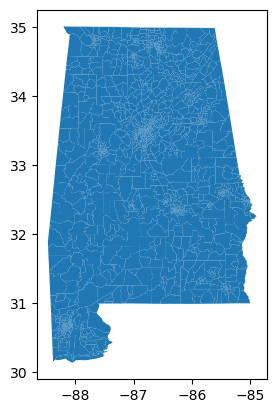

In [9]:
#testing out the files before dowloading all 21
al_ct.plot()

In [10]:
ar_ct = gpd.read_file('../data/AR census/tl_2020_05_tract.shp')
dc_ct = gpd.read_file('../data/DC census/tl_2020_11_tract.shp')
de_ct = gpd.read_file('../data/DE census/tl_2020_10_tract.shp')
fl_ct = gpd.read_file('../data/FL census/tl_2020_12_tract.shp')
ga_ct = gpd.read_file('../data/GA census/tl_2020_13_tract.shp')
ky_ct = gpd.read_file('../data/KY census/tl_2020_21_tract.shp')
la_ct = gpd.read_file('../data/LA census/tl_2020_22_tract.shp')
md_ct = gpd.read_file('../data/MD census/tl_2020_24_tract.shp')
mo_ct = gpd.read_file('../data/MO census/tl_2020_29_tract.shp')
ms_ct = gpd.read_file('../data/MS census/tl_2020_28_tract.shp')
nc_ct = gpd.read_file('../data/NC census/tl_2020_37_tract.shp')
oh_ct = gpd.read_file('../data/OH census/tl_2020_39_tract.shp')
ok_ct = gpd.read_file('../data/OK census/tl_2020_40_tract.shp')
pa_ct = gpd.read_file('../data/PA census/tl_2020_42_tract.shp')
sc_ct = gpd.read_file('../data/SC census/tl_2020_45_tract.shp')
tn_ct = gpd.read_file('../data/TN census/tl_2020_47_tract.shp')
tx_ct = gpd.read_file('../data/TX census/tl_2020_48_tract.shp')
va_ct = gpd.read_file('../data/VA census/tl_2020_51_tract.shp')
vi_ct = gpd.read_file('../data/VI census/tl_2020_78_tract.shp')
wv_ct = gpd.read_file('../data/WV census/tl_2020_54_tract.shp')

al_ct1= al_ct.to_crs('EPSG:4326')
ar_ct1= ar_ct.to_crs('EPSG:4326')
dc_ct1= dc_ct.to_crs('EPSG:4326')
de_ct1= de_ct.to_crs('EPSG:4326')
fl_ct1= fl_ct.to_crs('EPSG:4326')
ga_ct1= ga_ct.to_crs('EPSG:4326')
ky_ct1= ky_ct.to_crs('EPSG:4326')
la_ct1= la_ct.to_crs('EPSG:4326')
md_ct1= md_ct.to_crs('EPSG:4326')
mo_ct1= mo_ct.to_crs('EPSG:4326')
ms_ct1= ms_ct.to_crs('EPSG:4326')
nc_ct1= nc_ct.to_crs('EPSG:4326')
oh_ct1= oh_ct.to_crs('EPSG:4326')
ok_ct1= ok_ct.to_crs('EPSG:4326')
pa_ct1= pa_ct.to_crs('EPSG:4326')
sc_ct1= sc_ct.to_crs('EPSG:4326')
tn_ct1= tn_ct.to_crs('EPSG:4326')
tx_ct1= tx_ct.to_crs('EPSG:4326')
va_ct1= va_ct.to_crs('EPSG:4326')
vi_ct1= vi_ct.to_crs('EPSG:4326')
wv_ct1= wv_ct.to_crs('EPSG:4326') 

merged_ct = gpd.pd.concat([ al_ct, ar_ct, dc_ct, de_ct, fl_ct, ga_ct, ky_ct, la_ct, md_ct, mo_ct, ms_ct, nc_ct, oh_ct, ok_ct, pa_ct, sc_ct, tn_ct, tx_ct, va_ct, vi_ct, wv_ct])
merged_ct.to_file("../data/census_tracts_21_states.shp")

In [11]:
merged_ct=gpd.read_file('../data/census_tracts_21_states.shp')

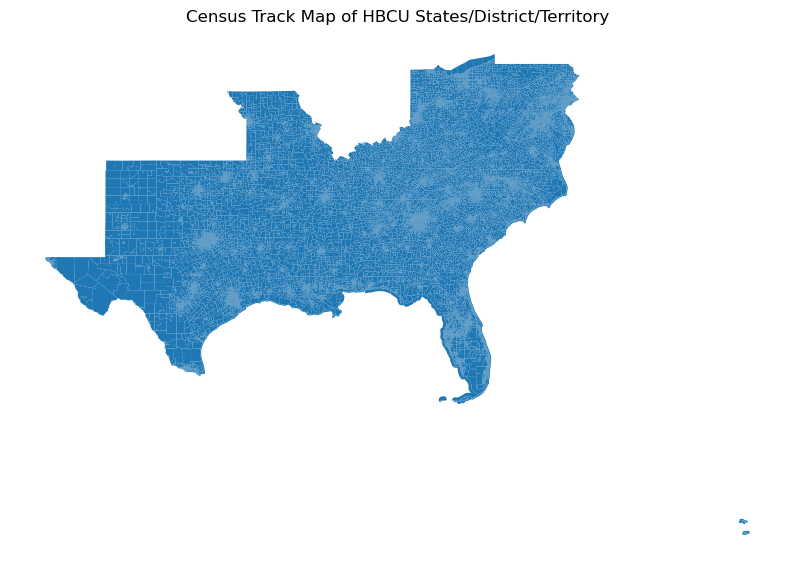

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
merged_ct.plot(ax=ax)
plt.title("Census Track Map of HBCU States/District/Territory")
ax.axis('off');

In [13]:
from geopy.distance import geodesic
from shapely.geometry import Point

In [14]:
merged_ct

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0          01      045  020801  01045020801   208.01   Census Tract 208.01   
1          01      017  954200  01017954200     9542     Census Tract 9542   
2          01      017  953800  01017953800     9538     Census Tract 9538   
3          01      017  954300  01017954300     9543     Census Tract 9543   
4          01      017  954700  01017954700     9547     Census Tract 9547   
...       ...      ...     ...          ...      ...                   ...   
40567      54      059  957100  54059957100     9571     Census Tract 9571   
40568      54      059  957700  54059957700     9577     Census Tract 9577   
40569      54      059  957600  54059957600     9576     Census Tract 9576   
40570      54      101  970102  54101970102  9701.02  Census Tract 9701.02   
40571      54      101  970101  54101970101  9701.01  Census Tract 9701.01   

       MTFCC FUNCSTAT      ALAND    AWATER     INTPTLAT      INTPTLON  \
0      G5020        S   19261326         0  +31.3971437  -085.6615959   
1      G5020        S   62998696     34641  +32.8341436  -085.2678516   
2      G5020        S  515692207  11516898  +33.0302580  -085.3867880   
3      G5020        S  132642536    178276  +32.7766468  -085.2734917   
4      G5020        S   38036820    264376  +32.7702191  -085.1744682   
...      ...      ...        ...       ...          ...           ...   
40567  G5020        S  281450737      6061  +37.8766154  -082.3121718   
40568  G5020        S  167185738   1902924  +37.5976514  -081.8838589   
40569  G5020        S  186194814    161067  +37.5995997  -082.0588289   
40570  G5020        S  420676844   1371888  +38.6168540  -080.3868135   
40571  G5020        S  327768843   1260451  +38.4921263  -080.5344175   

                                                geometry  
0      POLYGON ((-85.70064 31.38509, -85.70043 31.385...  
1      POLYGON ((-85.31549 32.80580, -85.31354 32.808...  
2      POLYGON ((-85.59345 33.00012, -85.59333 33.000...  
3      POLYGON ((-85.38077 32.78301, -85.37985 32.782...  
4      POLYGON ((-85.22897 32.74543, -85.22894 32.745...  
...                                                  ...  
40567  POLYGON ((-82.42064 37.84763, -82.42059 37.847...  
40568  POLYGON ((-81.99204 37.65671, -81.99194 37.657...  
40569  POLYGON ((-82.16949 37.61333, -82.16943 37.613...  
40570  POLYGON ((-80.54400 38.61600, -80.54389 38.616...  
40571  POLYGON ((-80.67829 38.50349, -80.67783 38.503...  

[40572 rows x 13 columns]

Source: https://www.census.gov/data/datasets/time-series/demo/labor-force/acs-employ.html

In [15]:
hbcu_merged['geometry'] = [Point(xy) for xy in zip(hbcu_merged['LONGITUDE'], hbcu_merged['LATITUDE'])]
geo_hbcu = gpd.GeoDataFrame(hbcu_merged, geometry='geometry', crs='EPSG:4326')
geo_hbcu['buffer'] = geo_hbcu['geometry'].buffer(25 / 69.0)  
geo_hbcu

C:\Users\joyce\AppData\Local\Temp\ipykernel_99924\417221718.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_hbcu['buffer'] = geo_hbcu['geometry'].buffer(25 / 69.0)


X             Y  OBJECTID  IPEDSID  \
0   -8.425464e+06  4.609303e+06        22   163338   
1   -9.802458e+06  3.593069e+06        27   102030   
2   -9.382946e+06  3.558622e+06       146   133650   
3   -1.095974e+07  3.428517e+06       325   227854   
4   -8.407892e+06  4.856108e+06       413   211608   
..            ...           ...       ...      ...   
96  -8.752139e+06  4.271082e+06      6089   199582   
97  -8.782952e+06  4.297077e+06      6200   199157   
98  -1.044562e+07  3.835148e+06      6204   160649   
99  -8.930586e+06  4.312610e+06      6218   199999   
100 -9.000988e+06  4.196958e+06      6221   198756   

                                               NAME  \
0              UNIVERSITY OF MARYLAND EASTERN SHORE   
1                    BISHOP STATE COMMUNITY COLLEGE   
2    FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY   
3                               ST PHILIP'S COLLEGE   
4                CHEYNEY UNIVERSITY OF PENNSYLVANIA   
..                                              ...   
96                     SAINT AUGUSTINE'S UNIVERSITY   
97                NORTH CAROLINA CENTRAL UNIVERSITY   
98                SOUTHERN UNIVERSITY AT SHREVEPORT   
99                   WINSTON-SALEM STATE UNIVERSITY   
100                      JOHNSON C SMITH UNIVERSITY   

                               ADDRESS           CITY STATE    ZIP  \
0                   J.T. WILLIAMS HALL  PRINCESS ANNE    MD  21853   
1               351 NORTH BROAD STREET         MOBILE    AL  36603   
2    1500 S MARTIN LUTHER KING JR BLVD    TALLAHASSEE    FL  32307   
3           1801 MARTIN LUTHER KING DR    SAN ANTONIO    TX  78203   
4               1837 UNIVERSITY CIRCLE        CHEYNEY    PA  19319   
..                                 ...            ...   ...    ...   
96                 1315 OAKWOOD AVENUE        RALEIGH    NC  27610   
97            1801 FAYETTEVILLE STREET         DURHAM    NC  27707   
98          3050 MARTIN LUTHER KING DR     SHREVEPORT    LA  71107   
99        601 MARTIN LUTHER KING JR DR  WINSTON-SALEM    NC  27110   
100             100 BEATTIES FORD ROAD      CHARLOTTE    NC  28216   

              ZIP4  ... HOUSING  DORM_CAP TOT_EMP     SHELTER_ID  unitid  \
0             1299  ...       1      1798     765  NOT AVAILABLE  163338   
1             5898  ...       2      -999     290  NOT AVAILABLE  102030   
2    NOT AVAILABLE  ...       1      2746    1830  NOT AVAILABLE  133650   
3             2098  ...       2      -999     836  NOT AVAILABLE  227854   
4             0200  ...       1       560     136  NOT AVAILABLE  211608   
..             ...  ...     ...       ...     ...            ...     ...   
96            2298  ...       1      1026     295  NOT AVAILABLE  199582   
97   NOT AVAILABLE  ...       1      3496    1404  NOT AVAILABLE  199157   
98   NOT AVAILABLE  ...       1       240     338  NOT AVAILABLE  160649   
99            0001  ...       1      2454     951  NOT AVAILABLE  199999   
100           5398  ...       1      1179     362  NOT AVAILABLE  198756   

                                   institution name  year  \
0              University of Maryland Eastern Shore  2022   
1                    Bishop State Community College  2022   
2    Florida Agricultural and Mechanical University  2022   
3                               St Philip's College  2022   
4                Cheyney University of Pennsylvania  2022   
..                                              ...   ...   
96                     Saint Augustine's University  2022   
97                North Carolina Central University  2022   
98                Southern University at Shreveport  2022   
99                   Winston-Salem State University  2022   
100                      Johnson C Smith University  2022   

     HD2022.Historically Black College or University  \
0                                                Yes   
1                                                Yes   
2                                                Ye

In [16]:
buffered_hbcu_locs = folium.Map(location=[30.4275125, -84.28844136], zoom_start=5, min_zoom=4, max_zoom=25)


for row_index, row_values in hbcu_merged.iterrows():
    loc = [row_values['LATITUDE'], row_values['LONGITUDE']]
    pop = str(row_values['institution name'])
    icon = folium.Icon(color="black", icon="fa-solid fa-building-columns", prefix='fa')

    marker = folium.Marker(
        location=loc,
        popup=pop,
        icon=icon
    )

    marker.add_to(buffered_hbcu_locs)

for x, geo_values in geo_hbcu.iterrows():
    buffer_geojson = folium.GeoJson(
        geo_values['buffer'],
        name='buffer',
        style_function=lambda x: {'fillColor': 'red', 'color': 'red'}
    )
    
    buffer_geojson.add_to(buffered_hbcu_locs)
buffered_hbcu_locs


In [17]:
merged_ct = merged_ct.set_geometry('geometry')
geo_hbcu = geo_hbcu.set_geometry('buffer')
tracts_within_buffer =gpd.sjoin(merged_ct, geo_hbcu, how='inner', op='within')
tracts_within_buffer.to_csv('../data/buffer_tracts.csv', index=False)
tracts_within_buffer.info()

C:\Users\joyce\anaconda3\envs\capstone_env\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\joyce\AppData\Local\Temp\ipykernel_99924\2710277863.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  tracts_within_buffer =gpd.sjoin(merged_ct, geo_hbcu, how='inner', op='within')


<class 'pandas.core.frame.DataFrame'>
Index: 23905 entries, 5 to 40440
Data columns (total 64 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   STATEFP                                          23905 non-null  object  
 1   COUNTYFP                                         23905 non-null  object  
 2   TRACTCE                                          23905 non-null  object  
 3   GEOID                                            23905 non-null  object  
 4   NAME_left                                        23905 non-null  object  
 5   NAMELSAD                                         23905 non-null  object  
 6   MTFCC                                            23905 non-null  object  
 7   FUNCSTAT                                         23905 non-null  object  
 8   ALAND                                            23905 non-null  int64   
 9   AWATER                

In [18]:
grouped_df =  tracts_within_buffer.groupby('institution name')['TRACTCE'].agg(list).reset_index()
grouped_df.columns = ['institution name', 'TRACTCE_list']
grouped_df.explode('TRACTCE_list')

institution name TRACTCE_list
0         Alabama A & M University       010623
0         Alabama A & M University       001301
0         Alabama A & M University       005703
0         Alabama A & M University       005704
0         Alabama A & M University       010705
..                             ...          ...
99  Xavier University of Louisiana       028600
99  Xavier University of Louisiana       030000
99  Xavier University of Louisiana       023004
99  Xavier University of Louisiana       029500
99  Xavier University of Louisiana       029000

[23905 rows x 2 columns]

Occupational Employment and Wage Statistics Source:  https://www.bls.gov/oes/tables.htm

In [19]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


In [20]:
conda install -c conda-forge openpyxl

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\joyce\anaconda3\envs\capstone_env

  added / updated specs:
    - openpyxl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         157 KB

The following packages will be UPDATED:

  certifi                           2023.11.17-pyhd8ed1ab_1 --> 2024.2.2-pyhd8ed1ab_0 



Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [21]:
occ_wages = pd.read_excel('../data/oesm22st/oesm22st/state_M2022_dl.xlsx',sheet_name='All May 2022 data')
occ_wages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37569 entries, 0 to 37568
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          37569 non-null  int64  
 1   AREA_TITLE    37569 non-null  object 
 2   AREA_TYPE     37569 non-null  int64  
 3   PRIM_STATE    37569 non-null  object 
 4   NAICS         37569 non-null  int64  
 5   NAICS_TITLE   37569 non-null  object 
 6   I_GROUP       37569 non-null  object 
 7   OWN_CODE      37569 non-null  int64  
 8   OCC_CODE      37569 non-null  object 
 9   OCC_TITLE     37569 non-null  object 
 10  O_GROUP       37569 non-null  object 
 11  TOT_EMP       37569 non-null  object 
 12  EMP_PRSE      37569 non-null  object 
 13  JOBS_1000     37569 non-null  object 
 14  LOC_QUOTIENT  37569 non-null  object 
 15  PCT_TOTAL     0 non-null      float64
 16  PCT_RPT       0 non-null      float64
 17  H_MEAN        37569 non-null  object 
 18  A_MEAN        37569 non-nu

In [22]:
wages_mean_state_occ_fam= occ_wages[occ_wages['O_GROUP'] == 'major'][['AREA_TITLE', 'OCC_TITLE','A_MEAN']]
wages_mean_state_occ_fam.reset_index(drop=True)

AREA_TITLE                                          OCC_TITLE  \
0            Alabama                             Management Occupations   
1            Alabama      Business and Financial Operations Occupations   
2            Alabama              Computer and Mathematical Occupations   
3            Alabama           Architecture and Engineering Occupations   
4            Alabama     Life, Physical, and Social Science Occupations   
...              ...                                                ...   
1183  Virgin Islands         Farming, Fishing, and Forestry Occupations   
1184  Virgin Islands            Construction and Extraction Occupations   
1185  Virgin Islands  Installation, Maintenance, and Repair Occupations   
1186  Virgin Islands                             Production Occupations   
1187  Virgin Islands     Transportation and Material Moving Occupations   

      A_MEAN  
0     110500  
1      76490  
2      92440  
3      97910  
4      69810  
...      ...  
1183   38810  
1184   49700  
1185   46710  
1186   40000  
1187   37340  

[1188 rows x 3 columns]

In [23]:
wages_mean_state_occ_fam.A_MEAN=wages_mean_state_occ_fam.A_MEAN.astype(int).fillna(0.00)
wages_mean_state_occ_fam=wages_mean_state_occ_fam.reset_index(drop=True)
wages_mean_state_occ_fam

AREA_TITLE                                          OCC_TITLE  \
0            Alabama                             Management Occupations   
1            Alabama      Business and Financial Operations Occupations   
2            Alabama              Computer and Mathematical Occupations   
3            Alabama           Architecture and Engineering Occupations   
4            Alabama     Life, Physical, and Social Science Occupations   
...              ...                                                ...   
1183  Virgin Islands         Farming, Fishing, and Forestry Occupations   
1184  Virgin Islands            Construction and Extraction Occupations   
1185  Virgin Islands  Installation, Maintenance, and Repair Occupations   
1186  Virgin Islands                             Production Occupations   
1187  Virgin Islands     Transportation and Material Moving Occupations   

      A_MEAN  
0     110500  
1      76490  
2      92440  
3      97910  
4      69810  
...      ...  
1183   38810  
1184   49700  
1185   46710  
1186   40000  
1187   37340  

[1188 rows x 3 columns]

In [24]:
states= {'Alabama', 'Arkansas', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Maryland',
        'Missouri', 'Mississippi', 'North Carolina', 'Ohio', 'Oklahoma','Pennsylvania', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 
        'Virgin Islands', 'West Virginia'}
filtered_wages_occ= wages_mean_state_occ_fam.loc[wages_mean_state_occ_fam['AREA_TITLE'].isin(states)].copy()
filtered_wages_occ

AREA_TITLE                                          OCC_TITLE  \
0            Alabama                             Management Occupations   
1            Alabama      Business and Financial Operations Occupations   
2            Alabama              Computer and Mathematical Occupations   
3            Alabama           Architecture and Engineering Occupations   
4            Alabama     Life, Physical, and Social Science Occupations   
...              ...                                                ...   
1183  Virgin Islands         Farming, Fishing, and Forestry Occupations   
1184  Virgin Islands            Construction and Extraction Occupations   
1185  Virgin Islands  Installation, Maintenance, and Repair Occupations   
1186  Virgin Islands                             Production Occupations   
1187  Virgin Islands     Transportation and Material Moving Occupations   

      A_MEAN  
0     110500  
1      76490  
2      92440  
3      97910  
4      69810  
...      ...  
1183   38810  
1184   49700  
1185   46710  
1186   40000  
1187   37340  

[462 rows x 3 columns]

In [25]:
pivot1= filtered_wages_occ.pivot_table(index='AREA_TITLE', columns='OCC_TITLE', values='A_MEAN')
top_wages_by_occ = pivot1.style.apply(lambda series: ['background-color: green' if val in series.nlargest(5).values else '' for val in series], axis=0)
pivot1
top_wages_by_occ

In [26]:
pivot2= filtered_wages_occ.pivot_table(index='AREA_TITLE', columns='OCC_TITLE', values='A_MEAN')
bottom_wages_by_occ = pivot2.style.apply(lambda series: ['background-color: red' if val in series.nsmallest(5).values else '' for val in series], axis=0)
pivot2
bottom_wages_by_occ

In [27]:
merged_ct['COUNTYFP'].unique()
counties={'045', '017', '125', '023', '117', '051', '109', '105', '097',
       '015', '089', '031', '113', '083', '073', '035', '009', '047',
       '101', '133', '059', '019', '121', '071', '049', '103', '123',
       '043', '079', '115', '053', '093', '001', '011', '111', '027',
       '081', '033', '037', '055', '007', '005', '095', '003', '119',
       '077', '131', '029', '025', '069', '087', '127', '107', '067',
       '091', '057', '129', '075', '039', '021', '065', '013', '099',
       '061', '063', '085', '041', '149', '145', '141', '137', '139',
       '143', '135', '147', '086', '247', '215', '153', '179', '195',
       '285', '185', '241', '159', '209', '297', '249', '303', '267',
       '157', '299', '243', '223', '287', '281', '235', '189', '173',
       '193', '237', '255', '155', '177', '321', '275', '221', '295',
       '251', '191', '169', '289', '175', '151', '199', '233', '309',
       '245', '305', '277', '165', '183', '317', '293', '307', '231',
       '311', '283', '227', '161', '211', '279', '253', '171', '213',
       '313', '273', '269', '205', '163', '315', '271', '207', '261',
       '219', '225', '301', '257', '217', '167', '259', '291', '201',
       '181', '263', '319', '229', '197', '265', '187', '239', '203',
       '510', '186', '375', '453', '335', '339', '409', '397', '491',
       '331', '485', '441', '439', '423', '363', '351', '443', '417',
       '377', '451', '455', '403', '407', '337', '477', '481', '493',
       '355', '469', '371', '401', '391', '381', '445', '463', '467',
       '419', '479', '437', '507', '369', '489', '385', '473', '329',
       '499', '483', '361', '327', '503', '349', '459', '505', '427',
       '325', '411', '465', '323', '373', '413', '389', '471', '475',
       '347', '383', '379', '495', '433', '395', '449', '457', '341',
       '387', '399', '393', '367', '365', '425', '497', '357', '431',
       '487', '359', '435', '429', '353', '415', '333', '461', '421',
       '345', '343', '501', '405', '447', '810', '683', '740', '700',
       '710', '670', '550', '640', '760', '650', '600', '770', '775',
       '680', '800', '570', '036', '580', '540', '630', '520', '678',
       '840', '530', '750', '790', '590', '620', '595', '685', '830',
       '660', '820', '690', '720', '610', '730', '735', '030', '010',
       '020'}

Labor force data by county, not seasonally adjusted, October 2022–November 2023 p
county level unemployment data Source: https://www.bls.gov/lau/tables.htm#mcounty

In [28]:
dtype_map = {'LAUS Code': str, 'State_FIPS_Code	': str, 'County_FIPS_Code': str, 'County Name/State Abbreviation': str,
            'Period	': str, 'Force': float, 'Employed':float,'Unemployed':float,'(%)':str}
unem_by_county= pd.read_csv('../data/laucntycur14/unemployment_county.csv', dtype=dtype_map)

unem_by_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45083 entries, 0 to 45082
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LAUS Code                       45081 non-null  object 
 1   State_FIPS_Code                 45080 non-null  float64
 2   County_FIPS_Code                45080 non-null  object 
 3   County Name/State Abbreviation  45080 non-null  object 
 4   Period                          45080 non-null  object 
 5   Force                           45080 non-null  float64
 6   Employed                        45080 non-null  float64
 7   Unemployed                      45080 non-null  float64
 8   (%)                             45082 non-null  object 
dtypes: float64(4), object(5)
memory usage: 3.1+ MB


In [29]:
unem_by_county['State_Abbrev'] = unem_by_county['County Name/State Abbreviation'].apply(lambda x: x[-2:]if pd.notna(x) else '')
unem_by_county

LAUS Code  State_FIPS_Code County_FIPS_Code  \
0       CN0100100000000              1.0              001   
1       CN0100300000000              1.0              003   
2       CN0100500000000              1.0              005   
3       CN0100700000000              1.0              007   
4       CN0100900000000              1.0              009   
...                 ...              ...              ...   
45078   CN7215100000000             72.0              151   
45079   CN7215300000000             72.0              153   
45080               NaN              NaN              NaN   
45081  p = preliminary.              NaN              NaN   
45082               NaN              NaN              NaN   

      County Name/State Abbreviation    Period     Force  Employed  \
0                 Autauga County, AL    Oct-22   26873.0   26292.0   
1                 Baldwin County, AL    Oct-22  103176.0  100899.0   
2                 Barbour County, AL    Oct-22    8328.0    7944.0   
3                    Bibb County, AL    Oct-22    8732.0    8520.0   
4                  Blount County, AL    Oct-22   25990.0   25421.0   
...                              ...       ...       ...       ...   
45078          Yabucoa Municipio, PR  Nov-23 p    9528.0    8790.0   
45079            Yauco Municipio, PR  Nov-23 p   10843.0    9737.0   
45080                            NaN       NaN       NaN       NaN   
45081                            NaN       NaN       NaN       NaN   
45082                            NaN       NaN       NaN       NaN   

       Unemployed                 (%) State_Abbrev  
0           581.0                 2.2           AL  
1          2277.0                 2.2           AL  
2           384.0                 4.6           AL  
3           212.0                 2.4           AL  
4           569.0                 2.2           AL  
...           ...                 ...          ...  
45078       738.0                 7.7           PR  
45079      1106.0                10.2           PR  
45080         NaN                 NaN               
45081         NaN  SOURCE:  BLS, LAUS               
45082         NaN     January 4, 2024               

[45083 rows x 10 columns]

In [30]:
unem_by_county['State_Abbrev'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'ia', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR', ''], dtype=object)

In [31]:
states_abbrev={'AL',  'AR', 'DE', 'DC', 'FL', 'GA',
       'KY', 'LA', 'MD', 'MS', 'MO',
       'NC', 'OH', 'OK', 'PA', 'SC',  'TN', 'TX',
        'VA', 'WV', 'VI'}
filtered_unemp= unem_by_county.loc[unem_by_county['State_Abbrev'].isin(states_abbrev)].copy()
filtered_unemp.reset_index(drop=True)

LAUS Code  State_FIPS_Code County_FIPS_Code  \
0      CN0100100000000              1.0              001   
1      CN0100300000000              1.0              003   
2      CN0100500000000              1.0              005   
3      CN0100700000000              1.0              007   
4      CN0100900000000              1.0              009   
...                ...              ...              ...   
23669  CN5410100000000             54.0              101   
23670  CN5410300000000             54.0              103   
23671  CN5410500000000             54.0              105   
23672  CN5410700000000             54.0              107   
23673  CN5410900000000             54.0              109   

      County Name/State Abbreviation    Period     Force  Employed  \
0                 Autauga County, AL    Oct-22   26873.0   26292.0   
1                 Baldwin County, AL    Oct-22  103176.0  100899.0   
2                 Barbour County, AL    Oct-22    8328.0    7944.0   
3                    Bibb County, AL    Oct-22    8732.0    8520.0   
4                  Blount County, AL    Oct-22   25990.0   25421.0   
...                              ...       ...       ...       ...   
23669             Webster County, WV  Nov-23 p    3112.0    2966.0   
23670              Wetzel County, WV  Nov-23 p    6303.0    5990.0   
23671                Wirt County, WV  Nov-23 p    2246.0    2133.0   
23672                Wood County, WV  Nov-23 p   36201.0   34851.0   
23673             Wyoming County, WV  Nov-23 p    7236.0    6934.0   

       Unemployed  (%) State_Abbrev  
0           581.0  2.2           AL  
1          2277.0  2.2           AL  
2           384.0  4.6           AL  
3           212.0  2.4           AL  
4           569.0  2.2           AL  
...           ...  ...          ...  
23669       146.0  4.7           WV  
23670       313.0    5           WV  
23671       113.0    5           WV  
23672      1350.0  3.7           WV  
23673       302.0  4.2           WV  

[23674 rows x 10 columns]

In [32]:
filtered_unemp_2022=filtered_unemp.loc[filtered_unemp['Period']=='Oct-22'].copy().reset_index(drop=True)
filtered_unemp_2022

LAUS Code  State_FIPS_Code County_FIPS_Code  \
0     CN0100100000000              1.0              001   
1     CN0100300000000              1.0              003   
2     CN0100500000000              1.0              005   
3     CN0100700000000              1.0              007   
4     CN0100900000000              1.0              009   
...               ...              ...              ...   
1686  CN5410100000000             54.0              101   
1687  CN5410300000000             54.0              103   
1688  CN5410500000000             54.0              105   
1689  CN5410700000000             54.0              107   
1690  CN5410900000000             54.0              109   

     County Name/State Abbreviation  Period     Force  Employed  Unemployed  \
0                Autauga County, AL  Oct-22   26873.0   26292.0       581.0   
1                Baldwin County, AL  Oct-22  103176.0  100899.0      2277.0   
2                Barbour County, AL  Oct-22    8328.0    7944.0       384.0   
3                   Bibb County, AL  Oct-22    8732.0    8520.0       212.0   
4                 Blount County, AL  Oct-22   25990.0   25421.0       569.0   
...                             ...     ...       ...       ...         ...   
1686             Webster County, WV  Oct-22    3118.0    2998.0       120.0   
1687              Wetzel County, WV  Oct-22    6416.0    6135.0       281.0   
1688                Wirt County, WV  Oct-22    2266.0    2159.0       107.0   
1689                Wood County, WV  Oct-22   36622.0   35346.0      1276.0   
1690             Wyoming County, WV  Oct-22    7239.0    6969.0       270.0   

      (%) State_Abbrev  
0     2.2           AL  
1     2.2           AL  
2     4.6           AL  
3     2.4           AL  
4     2.2           AL  
...   ...          ...  
1686  3.8           WV  
1687  4.4           WV  
1688  4.7           WV  
1689  3.5           WV  
1690  3.7           WV  

[1691 rows x 10 columns]

In [33]:
pd.set_option('display.max_rows', None)
hbcu_merged.COUNTY

0                  SOMERSET
1                    MOBILE
2                      LEON
3                     BEXAR
4                  DELAWARE
5                    SHELBY
6                   BAMBERG
7                TUSCALOOSA
8                 JEFFERSON
9                MONTGOMERY
10                 RICHLAND
11                  PULASKI
12                   FULTON
13                 RICHMOND
14                   GREENE
15     DISTRICT OF COLUMBIA
16               ST. THOMAS
17           BALTIMORE CITY
18                 HARRISON
19                  VOLUSIA
20                     WAKE
21                    ROWAN
22                  ORLEANS
23                  ORLEANS
24                  MADISON
25                   DALLAS
26               MIAMI-DADE
27           ST. LOUIS CITY
28                JEFFERSON
29                   GREENE
30                 RICHLAND
31             HAMPTON CITY
32                JEFFERSON
33                  CHATHAM
34                  LINCOLN
35                JE

In [34]:
filtered_unemp_2022['County_Name'] = filtered_unemp_2022['County Name/State Abbreviation'].str.split(',').str[0]
filtered_unemp_2022

LAUS Code  State_FIPS_Code County_FIPS_Code  \
0     CN0100100000000              1.0              001   
1     CN0100300000000              1.0              003   
2     CN0100500000000              1.0              005   
3     CN0100700000000              1.0              007   
4     CN0100900000000              1.0              009   
5     CN0101100000000              1.0              011   
6     CN0101300000000              1.0              013   
7     CN0101500000000              1.0              015   
8     CN0101700000000              1.0              017   
9     CN0101900000000              1.0              019   
10    CN0102100000000              1.0              021   
11    CN0102300000000              1.0              023   
12    CN0102500000000              1.0              025   
13    CN0102700000000              1.0              027   
14    CN0102900000000              1.0              029   
15    CN0103100000000              1.0              031   
16    CN0103300000000              1.0              033   
17    CN0103500000000              1.0              035   
18    CN0103700000000              1.0              037   
19    CN0103900000000              1.0              039   
20    CN0104100000000              1.0              041   
21    CN0104300000000              1.0              043   
22    CN0104500000000              1.0              045   
23    CN0104700000000              1.0              047   
24    CN0104900000000              1.0              049   
25    CN0105100000000              1.0              051   
26    CN0105300000000              1.0              053   
27    CN0105500000000              1.0              055   
28    CN0105700000000              1.0              057   
29    CN0105900000000              1.0              059   
30    CN0106100000000              1.0              061   
31    CN0106300000000              1.0              063   
32    CN0106500000000              1.0              065   
33    CN0106700000000              1.0              067   
34    CN0106900000000              1.0              069   
35    CN0107100000000              1.0              071   
36    CN0107300000000              1.0              073   
37    CN0107500000000              1.0              075   
38    CN0107700000000              1.0              077   
39    CN0107900000000              1.0              079   
40    CN0108100000000              1.0              081   
41    CN0108300000000              1.0              083   
42    CN0108500000000              1.0              085   
43    CN0108700000000              1.0              087   
44    CN0108900000000              1.0              089   
45    CN0109100000000              1.0              091   
46    CN0109300000000              1.0              093   
47    CN0109500000000              1.0              095   
48    CN0109700000000              1.0              097   
49    CN0109900000000              1.0              099   
50    CN0110100000000              1.0              101   
51    CN0110300000000              1.0              103   
52    CN0110500000000              1.0              105   
53    CN0110700000000              1.0              107   
54    CN0110900000000              1.0              109   
55    CN0111100000000              1.0              111   
56    CN0111300000000              1.0              113   
57    CN0111500000000              1.0              115   
58    CN0111700000000              1.0              117   
59    CN0111900000000              1.0              119   
60    CN0112100000000              1.0              121   
61    CN0112300000000              1.0              123   
62    CN0112500000000              1.0              125   
63    CN0112700000000              1.0              127   
64    CN0112900000000              1.0              129   
65    CN0113100000000              1.0              131   
66    CN0113300000000              1.0              133   


In [35]:
pd.set_option('display.max_rows', None)
filtered_unemp_2022['County_Name']=filtered_unemp_2022['County_Name'].str.replace('County','')
filtered_unemp_2022['County_Name']=filtered_unemp_2022['County_Name'].str.upper()
filtered_unemp_2022['County_Name']

0                          AUTAUGA 
1                          BALDWIN 
2                          BARBOUR 
3                             BIBB 
4                           BLOUNT 
5                          BULLOCK 
6                           BUTLER 
7                          CALHOUN 
8                         CHAMBERS 
9                         CHEROKEE 
10                         CHILTON 
11                         CHOCTAW 
12                          CLARKE 
13                            CLAY 
14                        CLEBURNE 
15                          COFFEE 
16                         COLBERT 
17                         CONECUH 
18                           COOSA 
19                       COVINGTON 
20                        CRENSHAW 
21                         CULLMAN 
22                            DALE 
23                          DALLAS 
24                          DEKALB 
25                          ELMORE 
26                        ESCAMBIA 
27                          

In [36]:
slice=['NAME','CITY','STATE', 'COUNTY', 'COUNTYFIPS', 'IPEDSID','ZIP']
new1=hbcu_merged[slice]

In [37]:
new1

NAME                CITY  \
0                 UNIVERSITY OF MARYLAND EASTERN SHORE       PRINCESS ANNE   
1                       BISHOP STATE COMMUNITY COLLEGE              MOBILE   
2       FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY         TALLAHASSEE   
3                                  ST PHILIP'S COLLEGE         SAN ANTONIO   
4                   CHEYNEY UNIVERSITY OF PENNSYLVANIA             CHEYNEY   
5                                LE MOYNE-OWEN COLLEGE             MEMPHIS   
6                                     VOORHEES COLLEGE             DENMARK   
7                      SHELTON STATE COMMUNITY COLLEGE          TUSCALOOSA   
8                       LAWSON STATE COMMUNITY COLLEGE          BIRMINGHAM   
9          H COUNCILL TRENHOLM STATE COMMUNITY COLLEGE          MONTGOMERY   
10                                    ALLEN UNIVERSITY            COLUMBIA   
11                                     SHORTER COLLEGE       N LITTLE ROCK   
12                            CLARK ATLANTA UNIVERSITY             ATLANTA   
13                                       PAINE COLLEGE             AUGUSTA   
14                            CENTRAL STATE UNIVERSITY         WILBERFORCE   
15              UNIVERSITY OF THE DISTRICT OF COLUMBIA          WASHINGTON   
16                    UNIVERSITY OF THE VIRGIN ISLANDS    CHARLOTTE AMALIE   
17                             MORGAN STATE UNIVERSITY           BALTIMORE   
18                                       WILEY COLLEGE            MARSHALL   
19                          BETHUNE-COOKMAN UNIVERSITY       DAYTONA BEACH   
20                                     SHAW UNIVERSITY             RALEIGH   
21                                 LIVINGSTONE COLLEGE           SALISBURY   
22                  SOUTHERN UNIVERSITY AT NEW ORLEANS         NEW ORLEANS   
23                      XAVIER UNIVERSITY OF LOUISIANA         NEW ORLEANS   
24                                  OAKWOOD UNIVERSITY          HUNTSVILLE   
25                                    SELMA UNIVERSITY               SELMA   
26                         FLORIDA MEMORIAL UNIVERSITY       MIAMI GARDENS   
27                       HARRIS-STOWE STATE UNIVERSITY         SAINT LOUIS   
28                         SIMMONS COLLEGE OF KENTUCKY          LOUISVILLE   
29                              WILBERFORCE UNIVERSITY         WILBERFORCE   
30                                    BENEDICT COLLEGE            COLUMBIA   
31                                  HAMPTON UNIVERSITY             HAMPTON   
32                UNIVERSITY OF ARKANSAS AT PINE BLUFF          PINE BLUFF   
33                           SAVANNAH STATE UNIVERSITY            SAVANNAH   
34                          GRAMBLING STATE UNIVERSITY           GRAMBLING   
35                                       MILES COLLEGE           FAIRFIELD   
36                                   TALLADEGA COLLEGE           TALLADEGA   
37                             ALBANY STATE UNIVERSITY              ALBANY   
38                                     SPELMAN COLLEGE             ATLANTA   
39                             BLUEFIELD STATE COLLEGE           BLUEFIELD   
40                          TENNESSEE STATE UNIVERSITY           NASHVILLE   
41                            AMERICAN BAPTIST COLLEGE           NASHVILLE   
42                                     FISK UNIVERSITY           NASHVILLE   
43                            ALABAMA STATE UNIVERSITY          MONTGOMERY   
44                             PHILANDER SMITH COLLEGE         LITTLE ROCK   
45                           DELAWARE STATE UNIVERSITY               DOVER   
46                      SOUTHERN UNIVERSITY LAW CENTER         BATON ROUGE   
47              INTERDENOMINATIONAL THEOLOGICAL CENTER             ATLANTA   
48                             COPPIN STATE UNIVERSITY           BALTIMORE   
49                              BOWIE STATE UNIVERSITY               BOWIE   
50                                   HOWARD UNIVERSITY          WASHINGT

In [38]:
filtered_unemp_2022['State_FIPS_Code']=filtered_unemp_2022['State_FIPS_Code'].astype(str)
filtered_unemp_2022['State_FIPS_Code']=filtered_unemp_2022['State_FIPS_Code'].astype(str).apply(lambda x: x.split('.')[0].zfill(2))

In [39]:
filtered_unemp_2022

LAUS Code State_FIPS_Code County_FIPS_Code  \
0     CN0100100000000              01              001   
1     CN0100300000000              01              003   
2     CN0100500000000              01              005   
3     CN0100700000000              01              007   
4     CN0100900000000              01              009   
5     CN0101100000000              01              011   
6     CN0101300000000              01              013   
7     CN0101500000000              01              015   
8     CN0101700000000              01              017   
9     CN0101900000000              01              019   
10    CN0102100000000              01              021   
11    CN0102300000000              01              023   
12    CN0102500000000              01              025   
13    CN0102700000000              01              027   
14    CN0102900000000              01              029   
15    CN0103100000000              01              031   
16    CN0103300000000              01              033   
17    CN0103500000000              01              035   
18    CN0103700000000              01              037   
19    CN0103900000000              01              039   
20    CN0104100000000              01              041   
21    CN0104300000000              01              043   
22    CN0104500000000              01              045   
23    CN0104700000000              01              047   
24    CN0104900000000              01              049   
25    CN0105100000000              01              051   
26    CN0105300000000              01              053   
27    CN0105500000000              01              055   
28    CN0105700000000              01              057   
29    CN0105900000000              01              059   
30    CN0106100000000              01              061   
31    CN0106300000000              01              063   
32    CN0106500000000              01              065   
33    CN0106700000000              01              067   
34    CN0106900000000              01              069   
35    CN0107100000000              01              071   
36    CN0107300000000              01              073   
37    CN0107500000000              01              075   
38    CN0107700000000              01              077   
39    CN0107900000000              01              079   
40    CN0108100000000              01              081   
41    CN0108300000000              01              083   
42    CN0108500000000              01              085   
43    CN0108700000000              01              087   
44    CN0108900000000              01              089   
45    CN0109100000000              01              091   
46    CN0109300000000              01              093   
47    CN0109500000000              01              095   
48    CN0109700000000              01              097   
49    CN0109900000000              01              099   
50    CN0110100000000              01              101   
51    CN0110300000000              01              103   
52    CN0110500000000              01              105   
53    CN0110700000000              01              107   
54    CN0110900000000              01              109   
55    CN0111100000000              01              111   
56    CN0111300000000              01              113   
57    CN0111500000000              01              115   
58    CN0111700000000              01              117   
59    CN0111900000000              01              119   
60    CN0112100000000              01              121   
61    CN0112300000000              01              123   
62    CN0112500000000              01              125   
63    CN0112700000000              01              127   
64    CN0112900000000              01              129   
65    CN0113100000000              01              131   
66    CN0113300000000              01              133   
67    CN0500100000000              05              001   
68    CN05

In [40]:
filtered_unemp_2022['COUNTYFIPS']=filtered_unemp_2022['State_FIPS_Code']+filtered_unemp_2022['County_FIPS_Code']
filtered_unemp_2022

LAUS Code State_FIPS_Code County_FIPS_Code  \
0     CN0100100000000              01              001   
1     CN0100300000000              01              003   
2     CN0100500000000              01              005   
3     CN0100700000000              01              007   
4     CN0100900000000              01              009   
5     CN0101100000000              01              011   
6     CN0101300000000              01              013   
7     CN0101500000000              01              015   
8     CN0101700000000              01              017   
9     CN0101900000000              01              019   
10    CN0102100000000              01              021   
11    CN0102300000000              01              023   
12    CN0102500000000              01              025   
13    CN0102700000000              01              027   
14    CN0102900000000              01              029   
15    CN0103100000000              01              031   
16    CN0103300000000              01              033   
17    CN0103500000000              01              035   
18    CN0103700000000              01              037   
19    CN0103900000000              01              039   
20    CN0104100000000              01              041   
21    CN0104300000000              01              043   
22    CN0104500000000              01              045   
23    CN0104700000000              01              047   
24    CN0104900000000              01              049   
25    CN0105100000000              01              051   
26    CN0105300000000              01              053   
27    CN0105500000000              01              055   
28    CN0105700000000              01              057   
29    CN0105900000000              01              059   
30    CN0106100000000              01              061   
31    CN0106300000000              01              063   
32    CN0106500000000              01              065   
33    CN0106700000000              01              067   
34    CN0106900000000              01              069   
35    CN0107100000000              01              071   
36    CN0107300000000              01              073   
37    CN0107500000000              01              075   
38    CN0107700000000              01              077   
39    CN0107900000000              01              079   
40    CN0108100000000              01              081   
41    CN0108300000000              01              083   
42    CN0108500000000              01              085   
43    CN0108700000000              01              087   
44    CN0108900000000              01              089   
45    CN0109100000000              01              091   
46    CN0109300000000              01              093   
47    CN0109500000000              01              095   
48    CN0109700000000              01              097   
49    CN0109900000000              01              099   
50    CN0110100000000              01              101   
51    CN0110300000000              01              103   
52    CN0110500000000              01              105   
53    CN0110700000000              01              107   
54    CN0110900000000              01              109   
55    CN0111100000000              01              111   
56    CN0111300000000              01              113   
57    CN0111500000000              01              115   
58    CN0111700000000              01              117   
59    CN0111900000000              01              119   
60    CN0112100000000              01              121   
61    CN0112300000000              01              123   
62    CN0112500000000              01              125   
63    CN0112700000000              01              127   
64    CN0112900000000              01              129   
65    CN0113100000000              01              131   
66    CN0113300000000              01              133   
67    CN0500100000000              05              001   
68    CN05

In [41]:
unemp_school = pd.merge(new1, filtered_unemp_2022,  on='COUNTYFIPS', how='left')
unemp_school

NAME                CITY  \
0                 UNIVERSITY OF MARYLAND EASTERN SHORE       PRINCESS ANNE   
1                       BISHOP STATE COMMUNITY COLLEGE              MOBILE   
2       FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY         TALLAHASSEE   
3                                  ST PHILIP'S COLLEGE         SAN ANTONIO   
4                   CHEYNEY UNIVERSITY OF PENNSYLVANIA             CHEYNEY   
5                                LE MOYNE-OWEN COLLEGE             MEMPHIS   
6                                     VOORHEES COLLEGE             DENMARK   
7                      SHELTON STATE COMMUNITY COLLEGE          TUSCALOOSA   
8                       LAWSON STATE COMMUNITY COLLEGE          BIRMINGHAM   
9          H COUNCILL TRENHOLM STATE COMMUNITY COLLEGE          MONTGOMERY   
10                                    ALLEN UNIVERSITY            COLUMBIA   
11                                     SHORTER COLLEGE       N LITTLE ROCK   
12                            CLARK ATLANTA UNIVERSITY             ATLANTA   
13                                       PAINE COLLEGE             AUGUSTA   
14                            CENTRAL STATE UNIVERSITY         WILBERFORCE   
15              UNIVERSITY OF THE DISTRICT OF COLUMBIA          WASHINGTON   
16                    UNIVERSITY OF THE VIRGIN ISLANDS    CHARLOTTE AMALIE   
17                             MORGAN STATE UNIVERSITY           BALTIMORE   
18                                       WILEY COLLEGE            MARSHALL   
19                          BETHUNE-COOKMAN UNIVERSITY       DAYTONA BEACH   
20                                     SHAW UNIVERSITY             RALEIGH   
21                                 LIVINGSTONE COLLEGE           SALISBURY   
22                  SOUTHERN UNIVERSITY AT NEW ORLEANS         NEW ORLEANS   
23                      XAVIER UNIVERSITY OF LOUISIANA         NEW ORLEANS   
24                                  OAKWOOD UNIVERSITY          HUNTSVILLE   
25                                    SELMA UNIVERSITY               SELMA   
26                         FLORIDA MEMORIAL UNIVERSITY       MIAMI GARDENS   
27                       HARRIS-STOWE STATE UNIVERSITY         SAINT LOUIS   
28                         SIMMONS COLLEGE OF KENTUCKY          LOUISVILLE   
29                              WILBERFORCE UNIVERSITY         WILBERFORCE   
30                                    BENEDICT COLLEGE            COLUMBIA   
31                                  HAMPTON UNIVERSITY             HAMPTON   
32                UNIVERSITY OF ARKANSAS AT PINE BLUFF          PINE BLUFF   
33                           SAVANNAH STATE UNIVERSITY            SAVANNAH   
34                          GRAMBLING STATE UNIVERSITY           GRAMBLING   
35                                       MILES COLLEGE           FAIRFIELD   
36                                   TALLADEGA COLLEGE           TALLADEGA   
37                             ALBANY STATE UNIVERSITY              ALBANY   
38                                     SPELMAN COLLEGE             ATLANTA   
39                             BLUEFIELD STATE COLLEGE           BLUEFIELD   
40                          TENNESSEE STATE UNIVERSITY           NASHVILLE   
41                            AMERICAN BAPTIST COLLEGE           NASHVILLE   
42                                     FISK UNIVERSITY           NASHVILLE   
43                            ALABAMA STATE UNIVERSITY          MONTGOMERY   
44                             PHILANDER SMITH COLLEGE         LITTLE ROCK   
45                           DELAWARE STATE UNIVERSITY               DOVER   
46                      SOUTHERN UNIVERSITY LAW CENTER         BATON ROUGE   
47              INTERDENOMINATIONAL THEOLOGICAL CENTER             ATLANTA   
48                             COPPIN STATE UNIVERSITY           BALTIMORE   
49                              BOWIE STATE UNIVERSITY               BOWIE   
50                                   HOWARD UNIVERSITY          WASHINGT

In [42]:
drops = ['LAUS Code', 'State_FIPS_Code', 'County_FIPS_Code','(%)',]
unemp_school.drop(columns=drops, axis=1, inplace=True)

In [43]:
unemp_school

NAME                CITY  \
0                 UNIVERSITY OF MARYLAND EASTERN SHORE       PRINCESS ANNE   
1                       BISHOP STATE COMMUNITY COLLEGE              MOBILE   
2       FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY         TALLAHASSEE   
3                                  ST PHILIP'S COLLEGE         SAN ANTONIO   
4                   CHEYNEY UNIVERSITY OF PENNSYLVANIA             CHEYNEY   
5                                LE MOYNE-OWEN COLLEGE             MEMPHIS   
6                                     VOORHEES COLLEGE             DENMARK   
7                      SHELTON STATE COMMUNITY COLLEGE          TUSCALOOSA   
8                       LAWSON STATE COMMUNITY COLLEGE          BIRMINGHAM   
9          H COUNCILL TRENHOLM STATE COMMUNITY COLLEGE          MONTGOMERY   
10                                    ALLEN UNIVERSITY            COLUMBIA   
11                                     SHORTER COLLEGE       N LITTLE ROCK   
12                            CLARK ATLANTA UNIVERSITY             ATLANTA   
13                                       PAINE COLLEGE             AUGUSTA   
14                            CENTRAL STATE UNIVERSITY         WILBERFORCE   
15              UNIVERSITY OF THE DISTRICT OF COLUMBIA          WASHINGTON   
16                    UNIVERSITY OF THE VIRGIN ISLANDS    CHARLOTTE AMALIE   
17                             MORGAN STATE UNIVERSITY           BALTIMORE   
18                                       WILEY COLLEGE            MARSHALL   
19                          BETHUNE-COOKMAN UNIVERSITY       DAYTONA BEACH   
20                                     SHAW UNIVERSITY             RALEIGH   
21                                 LIVINGSTONE COLLEGE           SALISBURY   
22                  SOUTHERN UNIVERSITY AT NEW ORLEANS         NEW ORLEANS   
23                      XAVIER UNIVERSITY OF LOUISIANA         NEW ORLEANS   
24                                  OAKWOOD UNIVERSITY          HUNTSVILLE   
25                                    SELMA UNIVERSITY               SELMA   
26                         FLORIDA MEMORIAL UNIVERSITY       MIAMI GARDENS   
27                       HARRIS-STOWE STATE UNIVERSITY         SAINT LOUIS   
28                         SIMMONS COLLEGE OF KENTUCKY          LOUISVILLE   
29                              WILBERFORCE UNIVERSITY         WILBERFORCE   
30                                    BENEDICT COLLEGE            COLUMBIA   
31                                  HAMPTON UNIVERSITY             HAMPTON   
32                UNIVERSITY OF ARKANSAS AT PINE BLUFF          PINE BLUFF   
33                           SAVANNAH STATE UNIVERSITY            SAVANNAH   
34                          GRAMBLING STATE UNIVERSITY           GRAMBLING   
35                                       MILES COLLEGE           FAIRFIELD   
36                                   TALLADEGA COLLEGE           TALLADEGA   
37                             ALBANY STATE UNIVERSITY              ALBANY   
38                                     SPELMAN COLLEGE             ATLANTA   
39                             BLUEFIELD STATE COLLEGE           BLUEFIELD   
40                          TENNESSEE STATE UNIVERSITY           NASHVILLE   
41                            AMERICAN BAPTIST COLLEGE           NASHVILLE   
42                                     FISK UNIVERSITY           NASHVILLE   
43                            ALABAMA STATE UNIVERSITY          MONTGOMERY   
44                             PHILANDER SMITH COLLEGE         LITTLE ROCK   
45                           DELAWARE STATE UNIVERSITY               DOVER   
46                      SOUTHERN UNIVERSITY LAW CENTER         BATON ROUGE   
47              INTERDENOMINATIONAL THEOLOGICAL CENTER             ATLANTA   
48                             COPPIN STATE UNIVERSITY           BALTIMORE   
49                              BOWIE STATE UNIVERSITY               BOWIE   
50                                   HOWARD UNIVERSITY          WASHINGT

In [44]:
unemp_school['Unemployment_Rate']=unemp_school['Unemployed']/unemp_school['Force']
unemp_school['Unemployment_Rate']=unemp_school['Unemployment_Rate'].round(4)*100
unemp_school

NAME                CITY  \
0                 UNIVERSITY OF MARYLAND EASTERN SHORE       PRINCESS ANNE   
1                       BISHOP STATE COMMUNITY COLLEGE              MOBILE   
2       FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY         TALLAHASSEE   
3                                  ST PHILIP'S COLLEGE         SAN ANTONIO   
4                   CHEYNEY UNIVERSITY OF PENNSYLVANIA             CHEYNEY   
5                                LE MOYNE-OWEN COLLEGE             MEMPHIS   
6                                     VOORHEES COLLEGE             DENMARK   
7                      SHELTON STATE COMMUNITY COLLEGE          TUSCALOOSA   
8                       LAWSON STATE COMMUNITY COLLEGE          BIRMINGHAM   
9          H COUNCILL TRENHOLM STATE COMMUNITY COLLEGE          MONTGOMERY   
10                                    ALLEN UNIVERSITY            COLUMBIA   
11                                     SHORTER COLLEGE       N LITTLE ROCK   
12                            CLARK ATLANTA UNIVERSITY             ATLANTA   
13                                       PAINE COLLEGE             AUGUSTA   
14                            CENTRAL STATE UNIVERSITY         WILBERFORCE   
15              UNIVERSITY OF THE DISTRICT OF COLUMBIA          WASHINGTON   
16                    UNIVERSITY OF THE VIRGIN ISLANDS    CHARLOTTE AMALIE   
17                             MORGAN STATE UNIVERSITY           BALTIMORE   
18                                       WILEY COLLEGE            MARSHALL   
19                          BETHUNE-COOKMAN UNIVERSITY       DAYTONA BEACH   
20                                     SHAW UNIVERSITY             RALEIGH   
21                                 LIVINGSTONE COLLEGE           SALISBURY   
22                  SOUTHERN UNIVERSITY AT NEW ORLEANS         NEW ORLEANS   
23                      XAVIER UNIVERSITY OF LOUISIANA         NEW ORLEANS   
24                                  OAKWOOD UNIVERSITY          HUNTSVILLE   
25                                    SELMA UNIVERSITY               SELMA   
26                         FLORIDA MEMORIAL UNIVERSITY       MIAMI GARDENS   
27                       HARRIS-STOWE STATE UNIVERSITY         SAINT LOUIS   
28                         SIMMONS COLLEGE OF KENTUCKY          LOUISVILLE   
29                              WILBERFORCE UNIVERSITY         WILBERFORCE   
30                                    BENEDICT COLLEGE            COLUMBIA   
31                                  HAMPTON UNIVERSITY             HAMPTON   
32                UNIVERSITY OF ARKANSAS AT PINE BLUFF          PINE BLUFF   
33                           SAVANNAH STATE UNIVERSITY            SAVANNAH   
34                          GRAMBLING STATE UNIVERSITY           GRAMBLING   
35                                       MILES COLLEGE           FAIRFIELD   
36                                   TALLADEGA COLLEGE           TALLADEGA   
37                             ALBANY STATE UNIVERSITY              ALBANY   
38                                     SPELMAN COLLEGE             ATLANTA   
39                             BLUEFIELD STATE COLLEGE           BLUEFIELD   
40                          TENNESSEE STATE UNIVERSITY           NASHVILLE   
41                            AMERICAN BAPTIST COLLEGE           NASHVILLE   
42                                     FISK UNIVERSITY           NASHVILLE   
43                            ALABAMA STATE UNIVERSITY          MONTGOMERY   
44                             PHILANDER SMITH COLLEGE         LITTLE ROCK   
45                           DELAWARE STATE UNIVERSITY               DOVER   
46                      SOUTHERN UNIVERSITY LAW CENTER         BATON ROUGE   
47              INTERDENOMINATIONAL THEOLOGICAL CENTER             ATLANTA   
48                             COPPIN STATE UNIVERSITY           BALTIMORE   
49                              BOWIE STATE UNIVERSITY               BOWIE   
50                                   HOWARD UNIVERSITY          WASHINGT

In [45]:
unemp_school['Unemp_%_Rank']=unemp_school['Unemployment_Rate'].rank()
unemp_school=unemp_school.sort_values(by='Unemp_%_Rank')
unemp_school

NAME                CITY  \
92                                  LINCOLN UNIVERSITY      JEFFERSON CITY   
78   J. F. DRAKE STATE COMMUNITY AND TECHNICAL COLLEGE          HUNTSVILLE   
76                            ALABAMA A & M UNIVERSITY              NORMAL   
24                                  OAKWOOD UNIVERSITY          HUNTSVILLE   
7                      SHELTON STATE COMMUNITY COLLEGE          TUSCALOOSA   
66                                    STILLMAN COLLEGE          TUSCALOOSA   
26                         FLORIDA MEMORIAL UNIVERSITY       MIAMI GARDENS   
8                       LAWSON STATE COMMUNITY COLLEGE          BIRMINGHAM   
35                                       MILES COLLEGE           FAIRFIELD   
27                       HARRIS-STOWE STATE UNIVERSITY         SAINT LOUIS   
63                                    TOUGALOO COLLEGE            TOUGALOO   
53                             MEHARRY MEDICAL COLLEGE           NASHVILLE   
40                          TENNESSEE STATE UNIVERSITY           NASHVILLE   
41                            AMERICAN BAPTIST COLLEGE           NASHVILLE   
80                                 LANGSTON UNIVERSITY            LANGSTON   
71                               EDWARD WATERS COLLEGE        JACKSONVILLE   
42                                     FISK UNIVERSITY           NASHVILLE   
79                         HUSTON-TILLOTSON UNIVERSITY              AUSTIN   
2       FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY         TALLAHASSEE   
58                     GADSDEN STATE COMMUNITY COLLEGE             GADSDEN   
61                           VIRGINIA STATE UNIVERSITY          PETERSBURG   
36                                   TALLADEGA COLLEGE           TALLADEGA   
57                                  LINCOLN UNIVERSITY  LINCOLN UNIVERSITY   
91               SOUTHERN UNIVERSITY AND A & M COLLEGE         BATON ROUGE   
46                      SOUTHERN UNIVERSITY LAW CENTER         BATON ROUGE   
33                           SAVANNAH STATE UNIVERSITY            SAVANNAH   
19                          BETHUNE-COOKMAN UNIVERSITY       DAYTONA BEACH   
83                            ARKANSAS BAPTIST COLLEGE         LITTLE ROCK   
44                             PHILANDER SMITH COLLEGE         LITTLE ROCK   
11                                     SHORTER COLLEGE       N LITTLE ROCK   
9          H COUNCILL TRENHOLM STATE COMMUNITY COLLEGE          MONTGOMERY   
43                            ALABAMA STATE UNIVERSITY          MONTGOMERY   
1                       BISHOP STATE COMMUNITY COLLEGE              MOBILE   
20                                     SHAW UNIVERSITY             RALEIGH   
55                                     CLINTON COLLEGE           ROCK HILL   
96                        SAINT AUGUSTINE'S UNIVERSITY             RALEIGH   
47              INTERDENOMINATIONAL THEOLOGICAL CENTER             ATLANTA   
65                        MOREHOUSE SCHOOL OF MEDICINE             ATLANTA   
12                            CLARK ATLANTA UNIVERSITY             ATLANTA   
38                                     SPELMAN COLLEGE             ATLANTA   
64                                   MOREHOUSE COLLEGE             ATLANTA   
34                          GRAMBLING STATE UNIVERSITY           GRAMBLING   
97                   NORTH CAROLINA CENTRAL UNIVERSITY              DURHAM   
82                      WEST VIRGINIA STATE UNIVERSITY           INSTITUTE   
77                                 TUSKEGEE UNIVERSITY            TUSKEGEE   
10                                    ALLEN UNIVERSITY            COLUMBIA   
90                           KENTUCKY STATE UNIVERSITY           FRANKFORT   
30                                    BENEDICT COLLEGE            COLUMBIA   
49                              BOWIE STATE UNIVERSITY               BOWIE   
28                         SIMMONS COLLEGE OF KENTUCKY          LOUISVILLE   
74                            JACKSON STATE UNIVERSITY             JACKS

rental data Sourced: https://www.zillow.com/research/data/

In [46]:
rental_df=pd.read_csv('../data/Zip_zori_uc_sfrcondomfr_sm_month.csv')


In [47]:
rental_slice=['RegionName','City','2022-10-31']
rental_df_10_2022=rental_df[rental_slice]
rental_df_10_2022['City']=rental_df_10_2022['City'].str.upper()
rental_df_10_2022

C:\Users\joyce\AppData\Local\Temp\ipykernel_99924\1293038318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rental_df_10_2022['City']=rental_df_10_2022['City'].str.upper()


RegionName                      City    2022-10-31
0          77494                      KATY   1873.018235
1          77449                      KATY   1834.287621
2          77084                   HOUSTON   1817.108206
3          79936                   EL PASO   1372.593706
4          11385                  NEW YORK   2934.748578
5          78660              PFLUGERVILLE   1861.634061
6          11208                  NEW YORK   2371.036188
7          90011               LOS ANGELES           NaN
8          77433                   CYPRESS   1911.697088
9          60629                   CHICAGO   1056.205531
10         90650                   NORWALK   2353.395358
11         91331               LOS ANGELES           NaN
12         37013                 NASHVILLE   1709.784985
13         11236                  NEW YORK           NaN
14         10467                  NEW YORK   1717.571512
15         11373                  NEW YORK   2481.986203
16         11226                  NEW YORK   2619.122903
17         11207                  NEW YORK   2932.634307
18         30044             LAWRENCEVILLE   1990.086915
19         90044               LOS ANGELES   1950.682951
20         92336                   FONTANA   3239.370131
21         94565                 PITTSBURG   2561.374998
22         77573               LEAGUE CITY   1760.567470
23         92335                   FONTANA           NaN
24         90250                 HAWTHORNE   1797.140110
25         10025                  NEW YORK   3877.573309
26         75052             GRAND PRAIRIE   1720.532590
27         90805                LONG BEACH   1847.605228
28         11214                  NEW YORK   1857.112292
29         60618                   CHICAGO   1781.189796
30         93307               BAKERSFIELD   1804.349828
31         90280                SOUTH GATE           NaN
32         11234                  NEW YORK   2293.296067
33         91342               LOS ANGELES   1859.790111
34         92683               WESTMINSTER   2579.301454
35         10314                  NEW YORK   2342.805831
36         60639                   CHICAGO   1232.583148
37         78245               SAN ANTONIO   1544.569379
38         11219                  NEW YORK           NaN
39         92503                 RIVERSIDE   2407.392251
40         78521               BROWNSVILLE   1093.765636
41         11206                  NEW YORK   3371.639041
42         11221                  NEW YORK   3040.641609
43         10456                  NEW YORK   2264.457089
44         92345                  HESPERIA   2104.584687
45         77479                SUGAR LAND   2129.990585
46         91911               CHULA VISTA   2697.436835
47         30043             LAWRENCEVILLE   2172.057445
48         11223                  NEW YORK   1913.238072
49         78613                CEDAR PARK   1788.961593
50         11230                  NEW YORK   2467.874664
51         60647                   CHICAGO   1887.263210
52         93033                    OXNARD           NaN
53         95076               WATSONVILLE           NaN
54         92154                 SAN DIEGO   2912.672381
55         77429                   CYPRESS   1784.837565
56         10458                  NEW YORK   1865.441933
57         60804                    CICERO           NaN
58         11377                  NEW YORK   2378.932672
59         79938                   EL PASO   1605.795758
60         92804                   ANAHEIM   2276.585031
61         91710                     CHINO   2799.583951
62         93722                    FRESNO   2023.437431
63         94112             SAN FRANCISCO   3179.958375
64         99301                     PASCO   1641.078695
65         11235                  NEW YORK   2501.994507
66         60632                   CHICAGO   1170.116416
67         77584                  PEARLAND   1868.365832
68         11229                  NEW YORK   2045.400550
69         95823

In [49]:
rental_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NAME        1035 non-null   object 
 1   CITY        1035 non-null   object 
 2   STATE       1035 non-null   object 
 3   COUNTY      1035 non-null   object 
 4   COUNTYFIPS  1035 non-null   object 
 5   IPEDSID     1035 non-null   int64  
 6   ZIP         1035 non-null   int64  
 7   RegionName  1007 non-null   float64
 8   City        1007 non-null   object 
 9   2022-10-31  811 non-null    float64
dtypes: float64(2), int64(2), object(6)
memory usage: 81.0+ KB


In [65]:
grouped_rental=rental_school.groupby('NAME')['2022-10-31'].mean()
grouped_rental

NAME
ALABAMA A & M UNIVERSITY                             1023.592059
ALABAMA STATE UNIVERSITY                             1309.279695
ALBANY STATE UNIVERSITY                              1622.963495
ALCORN STATE UNIVERSITY                                      NaN
ALLEN UNIVERSITY                                     1334.509775
AMERICAN BAPTIST COLLEGE                             1828.030475
ARKANSAS BAPTIST COLLEGE                             1130.493954
BENEDICT COLLEGE                                     1334.509775
BENNETT COLLEGE                                      1343.285177
BETHUNE-COOKMAN UNIVERSITY                           1534.147105
BISHOP STATE COMMUNITY COLLEGE                       1057.500853
BLUEFIELD STATE COLLEGE                                      NaN
BOWIE STATE UNIVERSITY                               2035.223674
CENTRAL STATE UNIVERSITY                                     NaN
CHEYNEY UNIVERSITY OF PENNSYLVANIA                           NaN
CLAFLIN UNIVERSITY  

In [66]:
hbcu_merged

X             Y  OBJECTID  IPEDSID  \
0   -8.425464e+06  4.609303e+06        22   163338   
1   -9.802458e+06  3.593069e+06        27   102030   
2   -9.382946e+06  3.558622e+06       146   133650   
3   -1.095974e+07  3.428517e+06       325   227854   
4   -8.407892e+06  4.856108e+06       413   211608   
5   -1.002255e+07  4.180016e+06       418   220604   
6   -9.031362e+06  3.936185e+06       543   218919   
7   -9.747299e+06  3.911313e+06       605   102067   
8   -9.672577e+06  3.955411e+06       624   101569   
9   -9.611665e+06  3.809356e+06       625   102313   
10  -9.019110e+06  4.030192e+06       803   217624   
11  -1.027039e+07  4.131220e+06      1010   107840   
12  -9.396908e+06  3.995073e+06      1073   138947   
13  -9.127429e+06  3.957791e+06      1106   140720   
14  -9.337122e+06  4.824825e+06      1138   201690   
15  -8.578975e+06  4.713627e+06      1204   131399   
16  -7.232746e+06  2.077875e+06      1456   243665   
17  -8.525318e+06  4.771101e+06      1603   163453   
18  -1.050598e+07  3.834094e+06      1678   229887   
19  -9.020391e+06  3.402468e+06      1739   132602   
20  -8.753908e+06  4.269182e+06      1761   199643   
21  -8.959376e+06  4.255353e+06      1769   198862   
22  -1.002369e+07  3.506981e+06      1792   160630   
23  -1.003070e+07  3.498944e+06      1793   160904   
24  -9.646155e+06  4.130619e+06      1904   101912   
25  -9.688561e+06  3.818616e+06      1905   102058   
26  -8.935481e+06  2.988830e+06      1934   133979   
27  -1.004372e+07  4.669058e+06      1945   177551   
28  -9.547295e+06  4.613317e+06      2002   461759   
29  -9.337407e+06  4.823599e+06      2205   206491   
30  -9.019150e+06  4.030540e+06      2212   217721   
31  -8.497232e+06  4.442104e+06      2221   232265   
32  -1.024376e+07  4.061369e+06      2292   106412   
33  -9.023934e+06  3.766564e+06      2339   140960   
34  -1.032125e+07  3.832121e+06      2379   159009   
35  -9.674576e+06  3.959347e+06      2448   101675   
36  -9.586130e+06  3.953087e+06      2451   102298   
37  -9.366800e+06  3.707245e+06      2479   138716   
38  -9.396746e+06  3.994670e+06      2481   141060   
39  -9.043488e+06  4.476211e+06      2521   237215   
40  -9.665801e+06  4.323899e+06      2523   221838   
41  -9.661341e+06  4.328335e+06      2525   219505   
42  -9.663163e+06  4.323917e+06      2526   220181   
43  -9.606391e+06  3.811228e+06      2528   100724   
44  -1.027273e+07  4.128324e+06      2530   107600   
45  -8.409133e+06  4.748518e+06      2759   130934   
46  -1.015156e+07  3.571045e+06      2857   440916   
47  -9.396502e+06  3.995754e+06      2895   140146   
48  -8.533597e+06  4.766328e+06      3272   162283   
49  -8.544853e+06  4.724277e+06      3276   162007   
50  -8.573769e+06  4.710324e+06      3279   131520   
51  -8.811107e+06  4.494328e+06      3317   234137   
52  -1.061564e+07  3.467925e+06      3505   229063   
53  -9.663346e+06  4.323585e+06      3522   220792   
54  -1.077081e+07  3.852535e+06      3539   227429   
55  -9.021718e+06  4.152162e+06      3752   217891   
56  -9.030641e+06  3.936971e+06      3754   217989   
57  -8.452297e+06  4.838041e+06      3764   213598   
58  -9.572508e+06  4.027710e+06      3851   101240   
59  -9.000626e+06  3.961543e+06      3927   217873   
60  -1.059514e+07  3.840778e+06      4046   225885   
61  -8.618342e+06  4.472117e+06      4054   234155   
62  -9.000323e+06  3.961487e+06      4086   218733   
63  -1.003650e+07  3.816291e+06      4218   176406   
64  -9.397052e+06  3.995005e+06      4315   140553   
65  -9.396786e+06  3.994358e+06      4316   140562   
66  -9.749932e+06  3.921810e+06      4378   102270   
67  -8.621738e+06  4.517615e+06      4393   234164   
68  -1.014598e+07  3.747204e+06      4615   175342   
69  -1.002595e+07  3.503111e+06      4768   158802   
70  -8.944095e+06  4.020581e+06      4958   218399   
71  -9.093119e+06  3.547947e+06      4973   133526   
72  -1.071847e+07  3.860249e+06      4985   228486   
73  -1.061013e+07  3